Importing libraries that are going to be used throughout the notebook:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

from nltk.sentiment import SentimentIntensityAnalyzer
%matplotlib inline

Importing the Dataset:

In [2]:
df=pd.read_csv('reviews.csv')

Checking the number of null values:

In [3]:
df.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

We can just drop them:

In [4]:
df.dropna(inplace=True)

In [5]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


Lets take the subset we want to do a sentiment analysis for:

In [6]:
df_sent1=df[['comments']]

Rename the comments column to reviews to avoid later duplication in column names:

In [7]:
df.rename(columns={'comments':'reviews'},inplace=True)

In [8]:
df.shape

(84831, 6)

In [9]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,reviews
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


We are going ot use the 'TextBlob" library to do sentiment analysis to the reviews that was already subset from the main df:

In [10]:
def Analyze(df):
    """"
    input: 
    df: a column or a dataframe for sentiment analysis to be done on it
    
    output:
    object_df: a column of scores corresponding to the target text
    """
    def senti (phrase):
        #This function applies the sentiment analysis from the TextBlob library to the phrase that is passed to it
        # and returns the value of the sentiment only for that text
        
        blob = TextBlob(phrase)             
        return blob.sentiment[0]
    
    object_df=df.select_dtypes(include=['object'])
    for i in object_df.columns:
        object_df[i]=object_df[i].apply(senti)
    
    return object_df   
#df_sent1=df_sent1.apply(Translate)
analyzed_df=Analyze(df_sent1)
analyzed_df

,comments
0,0.433333
1,0.301136
2,0.410417
3,0.358333
4,0.493485
...,...
84844,0.194844
84845,0.311111
84846,0.000000
84847,0.216852


adding the scores back to the main dataframe:

In [11]:
df=pd.concat([df,analyzed_df],axis=1)

In [12]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,reviews,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.433333
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.301136
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.410417
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.358333
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.493485


Plotting the scores in histogram to see if it follows the normal distribution as per the law of large numbers:

<AxesSubplot:>

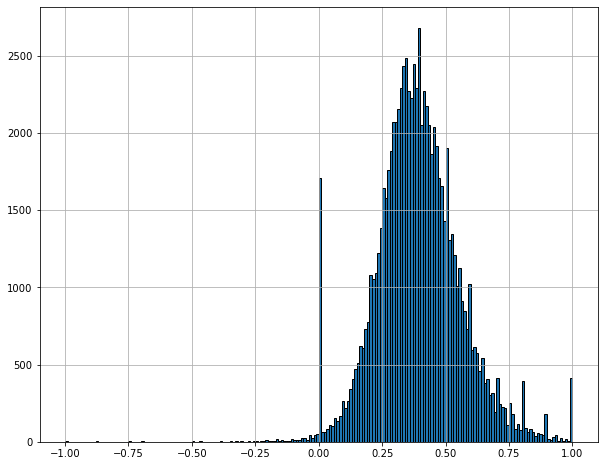

In [13]:
df.comments.hist(bins=200,edgecolor='black',figsize=(10,8))

<AxesSubplot:>

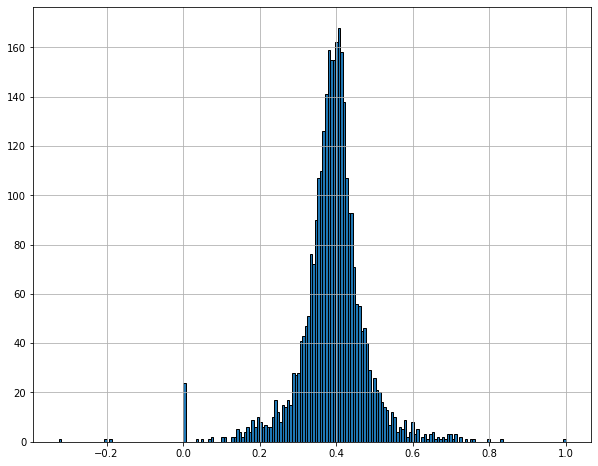

In [14]:
df.groupby('listing_id')['comments'].mean().hist(bins=200,edgecolor='black',figsize=(10,8))

It seems to be following almost a perfect normal distribution, with at Zero, assuming its for the non-english comments

lets take another subset and analyze it with a different library and take the average of both scores to avoid biases and possible errors:

In [15]:
df_sent2=df[['reviews']]

Here we will be using  the 'NLTK' library:

In [16]:
def Analyze_nltk(df):
    """"
    input: 
    df: a column or a dataframe for sentiment analysis to be done on it
    
    output:
    object_df: a column of scores corresponding to the target text
    """
    def sentim (phrase):
        sia = SentimentIntensityAnalyzer()        
        return sia.polarity_scores(phrase)['compound']
    
    object_df=df.select_dtypes(include=['object'])
    for i in object_df.columns:
        object_df[i]=object_df[i].apply(sentim)
    
    return object_df          
nltk_df=Analyze_nltk(df_sent2)
nltk_df

,reviews
0,0.7901
1,0.9872
2,0.8718
3,0.8313
4,0.9783
...,...
84844,0.9498
84845,0.8658
84846,0.0000
84847,0.7468


In [17]:
nltk_df

,reviews
0,0.7901
1,0.9872
2,0.8718
3,0.8313
4,0.9783
...,...
84844,0.9498
84845,0.8658
84846,0.0000
84847,0.7468


The scores seem to be different from the first analysis

Lets place both scores at the same table, compute their average and add them to the main dataframe:

In [18]:
frames=[analyzed_df,nltk_df]
combined_analysis=pd.concat(frames,axis=1)
combined_analysis.rename(columns={'comments':'TB_score','reviews':'nltk_score'},inplace=True)

In [23]:
combined_analysis['average_score']=(combined_analysis['TB_score']+combined_analysis['nltk_score'])/2

In [20]:
df=df.drop(['comments'],axis=1)

df=pd.concat([df,combined_analysis],axis=1)

df.head(50)

,listing_id,id,date,reviewer_id,reviewer_name,reviews,TB_score,nltk_score,average_score
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.433333,0.7901,0.611717
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.301136,0.9872,0.644168
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.410417,0.8718,0.641108
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.358333,0.8313,0.594817
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.493485,0.9783,0.735892
5,7202016,43979139,2015-08-23,1154501,Barent,"Kelly was great, place was great, just what I ...",0.491667,0.9349,0.713283
6,7202016,45265631,2015-09-01,37853266,Kevin,Kelly was great! Very nice and the neighborhoo...,0.480000,0.9421,0.711050
7,7202016,46749120,2015-09-13,24445447,Rick,hola all bnb erz - Just left Seattle where I h...,0.439583,0.9671,0.703342
8,7202016,47783346,2015-09-21,249583,Todd,Kelly's place is conveniently located on a qui...,0.171905,0.5562,0.364052
9,7202016,48388999,2015-09-26,38110731,Tatiana,"The place was really nice, clean, and the most...",0.460000,0.8613,0.660650


<AxesSubplot:>

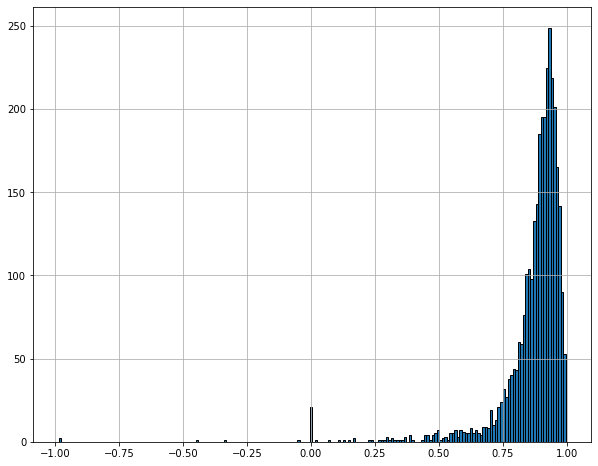

In [24]:
df.groupby('listing_id')['nltk_score'].mean().hist(bins=200,edgecolor='black',figsize=(10,8))

The NLTK scores seem to be heavily left skewed

Plotting the averaged combined score:

<AxesSubplot:>

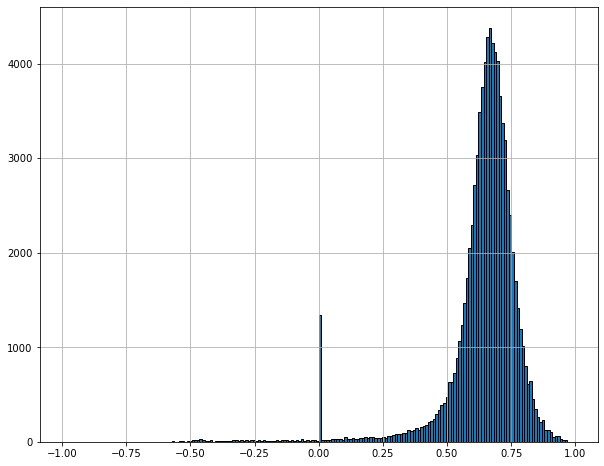

In [21]:
combined_analysis.average_score.hist(bins=200,edgecolor='black',figsize=(10,8))

The plot seems to have gotten smoother than before and shifted to the right changing the mean from around 0.4 to around 0.62

Lets add the neighbourhoods to see if there are some certain neighbourhoods that get higher reviews on average or not

In [22]:
df_list=pd.read_csv('listings.csv')



df_list=df_list[['id','zipcode','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']]

df3=pd.merge(df.drop('id',axis=1),df_list, left_on='listing_id',right_on='id')

In [46]:
df4=df3

ِAggregating the sum and average score per neighbourhood group and saving them to dataframes to be able to plot them:

In [47]:
sum_group_comments=pd.DataFrame(df4.groupby('neighbourhood_group_cleansed')['average_score'].sum().sort_values(ascending=False).reset_index())
mean_group_comments=pd.DataFrame(df4.groupby('neighbourhood_group_cleansed')['average_score'].mean().sort_values(ascending=False).reset_index())

In [49]:
mean_group_comments

,neighbourhood_group_cleansed,average_score
0,Ballard,0.650266
1,Queen Anne,0.648639
2,West Seattle,0.642713
3,Other neighborhoods,0.641655
4,Capitol Hill,0.638253
5,Cascade,0.638109
6,Rainier Valley,0.637558
7,Central Area,0.637200
8,Seward Park,0.636671
9,Delridge,0.636101


This is a graph of the sum of comments per neighbourhood which can be looked at as an indication to the popularity of the listings since we have no information about the bookings that actually occurred:

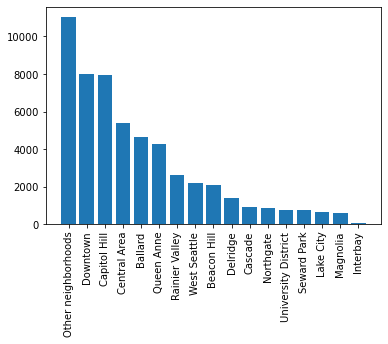

In [43]:
plt.bar(sum_group_comments.iloc[:,0],height=sum_group_comments.iloc[:,1])
plt.xticks(rotation=90)
plt.show();

Below is the average score per Neighborhood group:

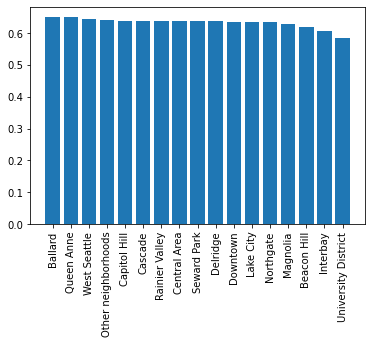

In [42]:
plt.bar(mean_group_comments.iloc[:,0],height=mean_group_comments.iloc[:,1])
plt.xticks(rotation=90)
plt.show();

Which does not seem to have a lot of variation to investigate